## General information

In this competition we have data about small mobile robot driving over different floor surfaces. We need to predict the floor type based on robot's sensor data.

This kernel uses content of my previous kernel: https://www.kaggle.com/artgor/where-do-the-robots-drive

Also I add bayesian optimization from this library: https://github.com/fmfn/BayesianOptimization

```
Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.
```
![](https://raw.githubusercontent.com/fmfn/BayesianOptimization/master/examples/bo_example.png)

*work in progress*

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

import json
import ast
import eli5
import shap
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import altair as alt
from  altair.vega import v3
from IPython.display import HTML
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

from bayes_opt import BayesianOptimization

In [2]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))



## Loading and basic exploring of data

In [3]:
train = pd.read_csv('../input/X_train.csv')
y = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')
sub = pd.read_csv('../input/sample_submission.csv')

### train and test data

For train and test we have the following data:
- ~3800 separate time-series
- 128 measurements in each time-series with data on robot orientation, angular velocity and linear acceleration

Target have 1 class per series, so we can aggregate train and test data on series. We have 9 unique classes as a target.

One more important point: measurements are taken in groups (73 groups in total), so this data could be used in validation. We'll try it later.

In [4]:
train.shape, test.shape

((487680, 13), (488448, 13))

In [5]:
train.head()

row_id          ...            linear_acceleration_Z
0    0_0          ...               -9.753200000000000
1    0_1          ...               -9.412800000000001
2    0_2          ...               -8.726699999999999
3    0_3          ...              -10.096000000000000
4    0_4          ...              -10.440999999999999

[5 rows x 13 columns]

In [6]:
test.head()

row_id          ...            linear_acceleration_Z
0    0_0          ...               -5.543900000000000
1    0_1          ...               -8.027300000000000
2    0_2          ...              -11.299000000000001
3    0_3          ...              -12.227000000000000
4    0_4          ...              -10.410000000000000

[5 rows x 13 columns]

In [7]:
train['series_id'].nunique(), test['series_id'].nunique()

(3810, 3816)

In [8]:
y['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [9]:
y['group_id'].nunique()

73

## Data exploration

### target

In [10]:
y['surface'].value_counts().reset_index().rename(columns={'index': 'target'})

target  surface
0                concrete      779
1                soft_pvc      732
2                    wood      607
3                   tiled      514
4           fine_concrete      363
5  hard_tiles_large_space      308
6              soft_tiles      297
7                  carpet      189
8              hard_tiles       21

In [11]:
target_count = y['surface'].value_counts().reset_index().rename(columns={'index': 'target'})
render(alt.Chart(target_count).mark_bar().encode(
    y=alt.Y("target:N", axis=alt.Axis(title='Surface'), sort=list(target_count['target'])),
    x=alt.X('surface:Q', axis=alt.Axis(title='Count')),
    tooltip=['target', 'surface']
).properties(title="Counts of target classes", width=400).interactive())

We have a serious disbalance, some classes exist only in several series.

### Orientation - quaternion coordinates

You could notice that there are 4 coordinates: X, Y, Z, W.

Usually we have X, Y, Z - Euler Angles. But Euler Angles are limited by a phenomenon called "gimbal lock," which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees. Quaternions provide an alternative measurement technique that does not suffer from gimbal lock. Quaternions are less intuitive than Euler Angles and the math can be a little more complicated.

Here are some articles about it:

http://www.chrobotics.com/library/understanding-quaternions

http://www.tobynorris.com/work/prog/csharp/quatview/help/orientations_and_quaternions.htm

Basically 3D coordinates are converted to 4D vectors.

### Feature distribution

In [12]:
train.head()

row_id          ...            linear_acceleration_Z
0    0_0          ...               -9.753200000000000
1    0_1          ...               -9.412800000000001
2    0_2          ...               -8.726699999999999
3    0_3          ...              -10.096000000000000
4    0_4          ...              -10.440999999999999

[5 rows x 13 columns]

Blue values show histograms for train data, green - test data.

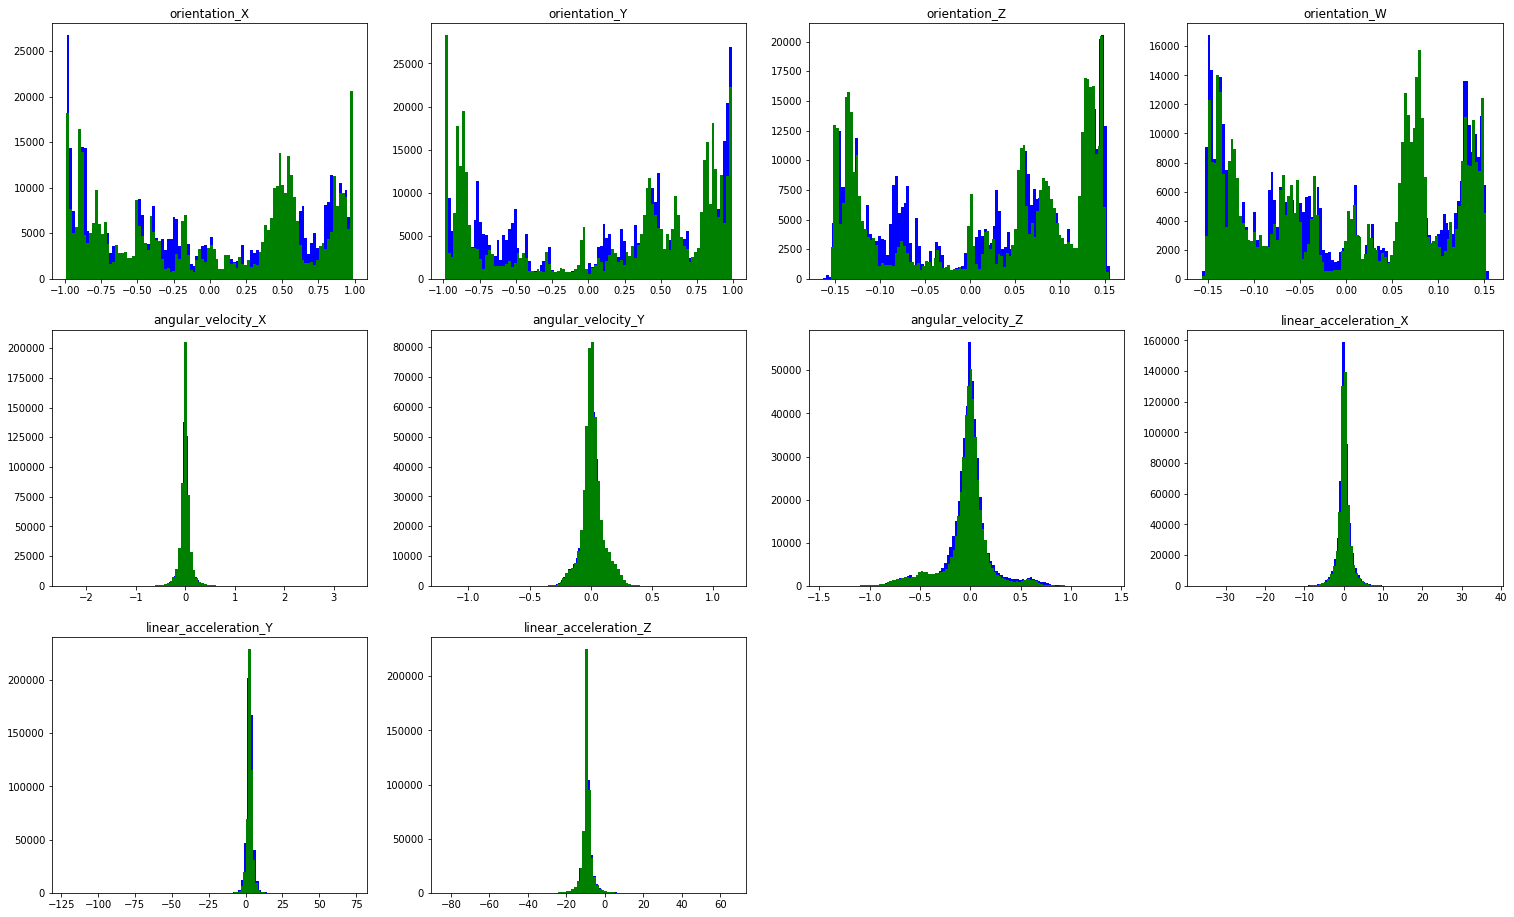

In [13]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(train[col], color='blue', bins=100)
    plt.hist(test[col], color='green', bins=100)
    plt.title(col)

Velocity and acceleration have normal distribution, orientation features seem to have normalized values (using tanh function).

Feature distributions in train and test are quite similar.

Let's have a look at the values of features in a single time-series

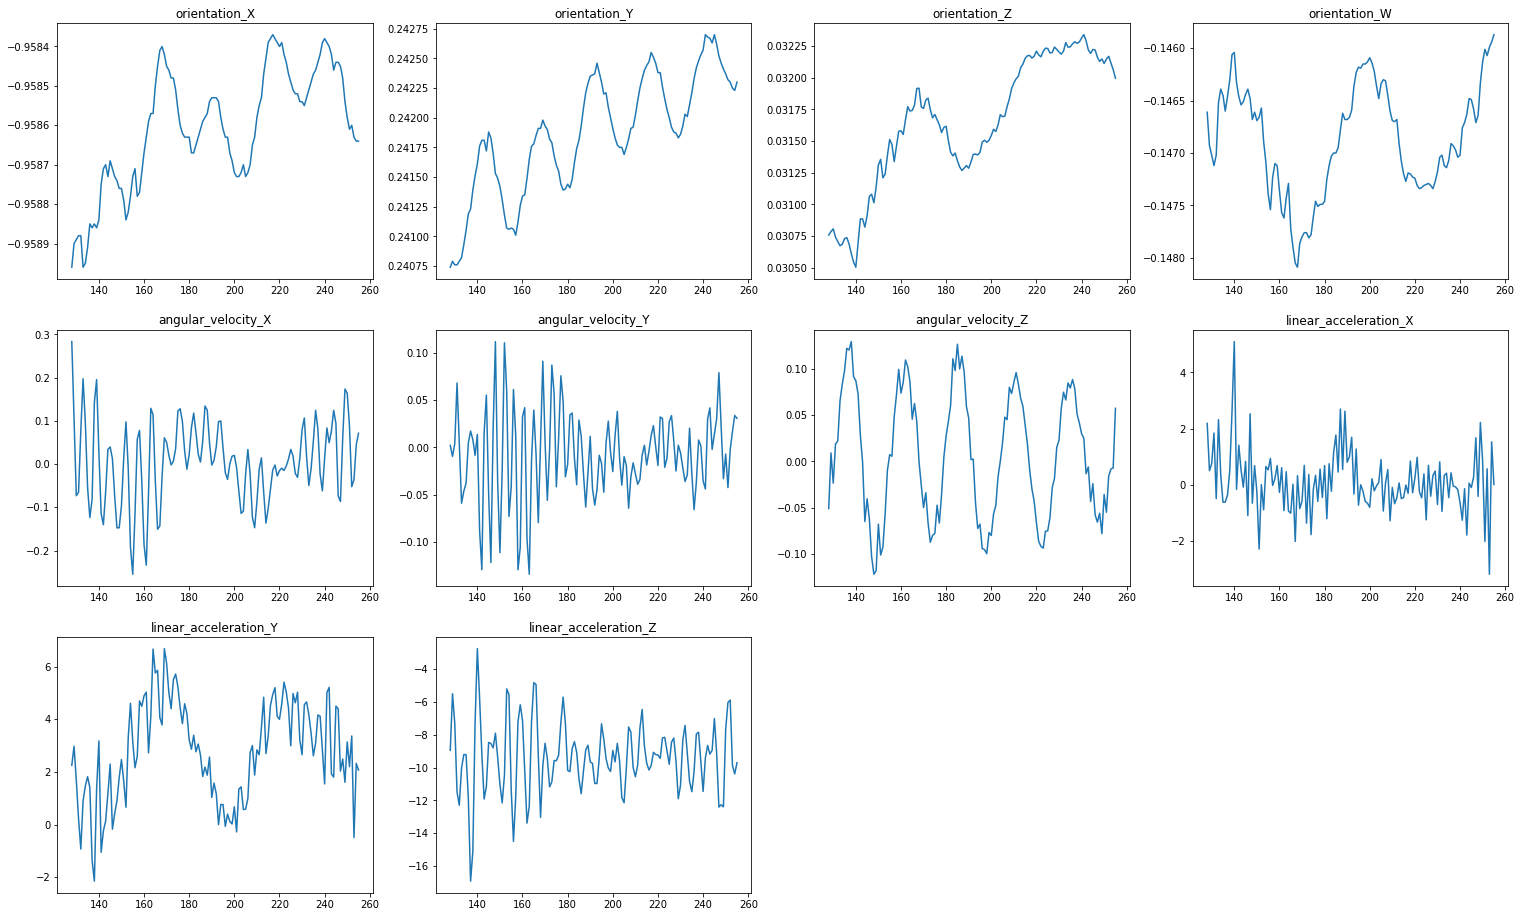

In [14]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(train.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(train.loc[train['series_id'] == 1, col])
    plt.title(col)

Hm. Don't see any patterns.

### Feature generation

I'll generate a lot of aggregate features. Descriptions will be done later. I use ideas from my kernel for another competition: https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples

In [15]:
train_df = train[['series_id']].drop_duplicates().reset_index(drop=True)

In [16]:
for col in train.columns:
    if 'orient' in col:
        scaler = StandardScaler()
        train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
        test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [17]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta
for col in tqdm_notebook(train.columns[3:]):
    train_df[col + '_mean'] = train.groupby(['series_id'])[col].mean()
    train_df[col + '_std'] = train.groupby(['series_id'])[col].std()
    train_df[col + '_max'] = train.groupby(['series_id'])[col].max()
    train_df[col + '_min'] = train.groupby(['series_id'])[col].min()
    train_df[col + '_max_to_min'] = train_df[col + '_max'] / train_df[col + '_min']

    for i in train_df['series_id']:
        train_df.loc[i, col + '_mean_change_abs'] = np.mean(np.diff(train.loc[train['series_id'] == i, col]))
        train_df.loc[i, col + '_mean_change_rate'] = calc_change_rate(train.loc[train['series_id'] == i, col])
        
        train_df.loc[i, col + '_q95'] = np.quantile(train.loc[train['series_id'] == i, col], 0.95)
        train_df.loc[i, col + '_q99'] = np.quantile(train.loc[train['series_id'] == i, col], 0.99)
        train_df.loc[i, col + '_q05'] = np.quantile(train.loc[train['series_id'] == i, col], 0.05)
        
        train_df.loc[i, col + '_abs_min'] = np.abs(train.loc[train['series_id'] == i, col]).min()
        train_df.loc[i, col + '_abs_max'] = np.abs(train.loc[train['series_id'] == i, col]).max()
        
        train_df.loc[i, col + '_trend'] = add_trend_feature(train.loc[train['series_id'] == i, col].values)
        train_df.loc[i, col + '_abs_trend'] = add_trend_feature(train.loc[train['series_id'] == i, col].values, abs_values=True)
        train_df.loc[i, col + '_abs_mean'] = np.abs(train.loc[train['series_id'] == i, col]).mean()
        train_df.loc[i, col + '_abs_std'] = np.abs(train.loc[train['series_id'] == i, col]).std()
        
        train_df.loc[i, col + '_mad'] = train.loc[train['series_id'] == i, col].mad()
        train_df.loc[i, col + '_kurt'] = train.loc[train['series_id'] == i, col].kurtosis()
        train_df.loc[i, col + '_skew'] = train.loc[train['series_id'] == i, col].skew()
        train_df.loc[i, col + '_med'] = train.loc[train['series_id'] == i, col].median()
        
        train_df.loc[i, col + '_Hilbert_mean'] = np.abs(hilbert(train.loc[train['series_id'] == i, col])).mean()
        
        train_df.loc[i, col + '_Hann_window_mean'] = (convolve(train.loc[train['series_id'] == i, col], hann(15), mode='same') / sum(hann(15))).mean()
        train_df.loc[i, col + '_classic_sta_lta1_mean'] = classic_sta_lta(train.loc[train['series_id'] == i, col], 10, 50).mean()

        train_df.loc[i, col + '_Moving_average_10_mean'] = train.loc[train['series_id'] == i, col].rolling(window=10).mean().mean(skipna=True)
        train_df.loc[i, col + '_Moving_average_16_mean'] = train.loc[train['series_id'] == i, col].rolling(window=16).mean().mean(skipna=True)
        train_df.loc[i, col + '_Moving_average_10_std'] = train.loc[train['series_id'] == i, col].rolling(window=10).std().mean(skipna=True)
        train_df.loc[i, col + '_Moving_average_16_std'] = train.loc[train['series_id'] == i, col].rolling(window=16).std().mean(skipna=True)
        
        train_df.loc[i, col + 'iqr'] = np.subtract(*np.percentile(train.loc[train['series_id'] == i, col], [75, 25]))
        train_df.loc[i, col + 'ave10'] = stats.trim_mean(train.loc[train['series_id'] == i, col], 0.1)


In [18]:
test_df = sub[['series_id']]

Feature generation for test data is the same.

In [19]:
for col in tqdm_notebook(test.columns[3:]):
    test_df[col + '_mean'] = test.groupby(['series_id'])[col].mean()
    test_df[col + '_std'] = test.groupby(['series_id'])[col].std()
    test_df[col + '_max'] = test.groupby(['series_id'])[col].max()
    test_df[col + '_min'] = test.groupby(['series_id'])[col].min()
    test_df[col + '_max_to_min'] = test_df[col + '_max'] / test_df[col + '_min']

    for i in test_df['series_id']:
        test_df.loc[i, col + '_mean_change_abs'] = np.mean(np.diff(test.loc[test['series_id'] == i, col]))
        test_df.loc[i, col + '_mean_change_rate'] = calc_change_rate(test.loc[test['series_id'] == i, col])
        
        test_df.loc[i, col + '_q95'] = np.quantile(test.loc[test['series_id'] == i, col], 0.95)
        test_df.loc[i, col + '_q99'] = np.quantile(test.loc[test['series_id'] == i, col], 0.99)
        test_df.loc[i, col + '_q05'] = np.quantile(test.loc[test['series_id'] == i, col], 0.05)
        
        test_df.loc[i, col + '_abs_min'] = np.abs(test.loc[test['series_id'] == i, col]).min()
        test_df.loc[i, col + '_abs_max'] = np.abs(test.loc[test['series_id'] == i, col]).max()
        
        test_df.loc[i, col + '_trend'] = add_trend_feature(test.loc[test['series_id'] == i, col].values)
        test_df.loc[i, col + '_abs_trend'] = add_trend_feature(test.loc[test['series_id'] == i, col].values, abs_values=True)
        test_df.loc[i, col + '_abs_mean'] = np.abs(test.loc[test['series_id'] == i, col]).mean()
        test_df.loc[i, col + '_abs_std'] = np.abs(test.loc[test['series_id'] == i, col]).std()
        
        test_df.loc[i, col + '_mad'] = test.loc[test['series_id'] == i, col].mad()
        test_df.loc[i, col + '_kurt'] = test.loc[test['series_id'] == i, col].kurtosis()
        test_df.loc[i, col + '_skew'] = test.loc[test['series_id'] == i, col].skew()
        test_df.loc[i, col + '_med'] = test.loc[test['series_id'] == i, col].median()
        
        test_df.loc[i, col + '_Hilbert_mean'] = np.abs(hilbert(test.loc[test['series_id'] == i, col])).mean()
        
        test_df.loc[i, col + '_Hann_window_mean'] = (convolve(test.loc[test['series_id'] == i, col], hann(15), mode='same') / sum(hann(15))).mean()
        test_df.loc[i, col + '_classic_sta_lta1_mean'] = classic_sta_lta(test.loc[test['series_id'] == i, col], 10, 50).mean()

        test_df.loc[i, col + '_Moving_average_10_mean'] = test.loc[test['series_id'] == i, col].rolling(window=10).mean().mean(skipna=True)
        test_df.loc[i, col + '_Moving_average_16_mean'] = test.loc[test['series_id'] == i, col].rolling(window=16).mean().mean(skipna=True)
        test_df.loc[i, col + '_Moving_average_10_std'] = test.loc[test['series_id'] == i, col].rolling(window=10).std().mean(skipna=True)
        test_df.loc[i, col + '_Moving_average_16_std'] = test.loc[test['series_id'] == i, col].rolling(window=16).std().mean(skipna=True)
        
        test_df.loc[i, col + 'iqr'] = np.subtract(*np.percentile(test.loc[test['series_id'] == i, col], [75, 25]))
        test_df.loc[i, col + 'ave10'] = stats.trim_mean(test.loc[test['series_id'] == i, col], 0.1)

In [20]:
train_df.head()

series_id             ...              linear_acceleration_Zave10
0          0             ...                      -9.328722115384615
1          1             ...                      -9.404213461538461
2          2             ...                      -9.396549038461538
3          3             ...                      -9.386403846153847
4          4             ...                      -9.358384615384615

[5 rows x 291 columns]

## Building model

In [21]:
n_fold = 3
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)

In [22]:
le = LabelEncoder()
le.fit(y['surface'])
y['surface'] = le.transform(y['surface'])

train_df = train_df.drop(['series_id'], axis=1)
test_df = test_df.drop(['series_id'], axis=1)

### Bayesian optimization

There are several steps in using this library for bayesian optimization:
* write a function to evaluate the hyperparameters. It should accept parameters as an input and return the value of the metric to maximize. If the metric should be minimized, then simply add `-` before the returned value;
* initialize `BayesianOptimization` and run `maximize` method;
* get optimized parameters.

In [23]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train_df.shape[0], 9))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y['surface'])):
        X_train, X_valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
        y_train, y_valid = y['surface'].iloc[train_idx], y['surface'].iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [24]:
params = {'colsample_bytree': (0.6, 0.8),
      'learning_rate': (.0001, .5), 
      'num_leaves': (2, 124), 
      'subsample': (0.6, 1), 
      'max_depth': (3, 120), 
      'reg_alpha': (.001, 15.0), 
      'reg_lambda': (.001, 15.0), 
      'min_split_gain': (.001, .03),
      'min_child_weight': (2, 80)}

bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points=5, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7603   |  0.7439   |  0.4777   |  44.58    |  75.17    |  0.01783  |  114.1    |  6.355    |  10.69    |  0.9902   |
|  2        |  0.8454   |  0.7524   |  0.4812   |  93.82    |  8.546    |  0.005686 |  101.9    |  1.4      |  6.01     |  0.9268   |
|  3        |  0.7579   |  0.7661   |  0.3273   |  118.1    |  48.91    |  0.008384 |  92.66    |  10.96    |  10.18    |  0.6695   |
|  4        |  0.8131   |  0.7005   |  0.2123   |  116.9    |  35.61    |  0.005229 |  44.32    |  1.744    |  6.267    |  0.8143   |
|  5        |  0.8178   |  0.7207   |  0.3902   |  106.6    |  11.67    |  0.0291   |  95.38    |  4.079    |  8.015    |  0.8419   |
|  6        |  0.7058   |  0.8      |  0.5      |  3.0      | 

In [25]:
bo.max['params']

{'colsample_bytree': 0.6000000029552217,
 'learning_rate': 0.5,
 'max_depth': 95.37523423764466,
 'min_child_weight': 2.0,
 'min_split_gain': 0.001,
 'num_leaves': 124.0,
 'reg_alpha': 0.001,
 'reg_lambda': 15.0,
 'subsample': 1.0}

Function to train models:

In [26]:
def eval_acc(preds, dtrain):
    labels = dtrain.get_label()
    return 'acc', accuracy_score(labels, preds.argmax(1)), True

def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros((len(X), 9))
    prediction = np.zeros((len(X_test), 9))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                    verbose=5000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict_proba(X_valid)
            score = accuracy_score(y_valid, y_pred_valid.argmax(1))
            print(f'Fold {fold_n}. Accuracy: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(accuracy_score(y_valid, y_pred_valid.argmax(1)))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Wed Apr 10 22:01:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.00422129	training's multi_logloss: 0.00422129	valid_1's multi_logloss: 0.467589	valid_1's multi_logloss: 0.467589
Fold 1 started at Wed Apr 10 22:01:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.00406078	training's multi_logloss: 0.00406078	valid_1's multi_logloss: 0.42051	valid_1's multi_logloss: 0.42051
Fold 2 started at Wed Apr 10 22:02:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[186]	training's multi_logloss: 0.00379367	training's multi_logloss: 0.00379367	valid_1's multi_logloss: 0.450939	valid_1's multi_logloss: 0.450939
CV mean score: 0.8457, std: 0.0054.


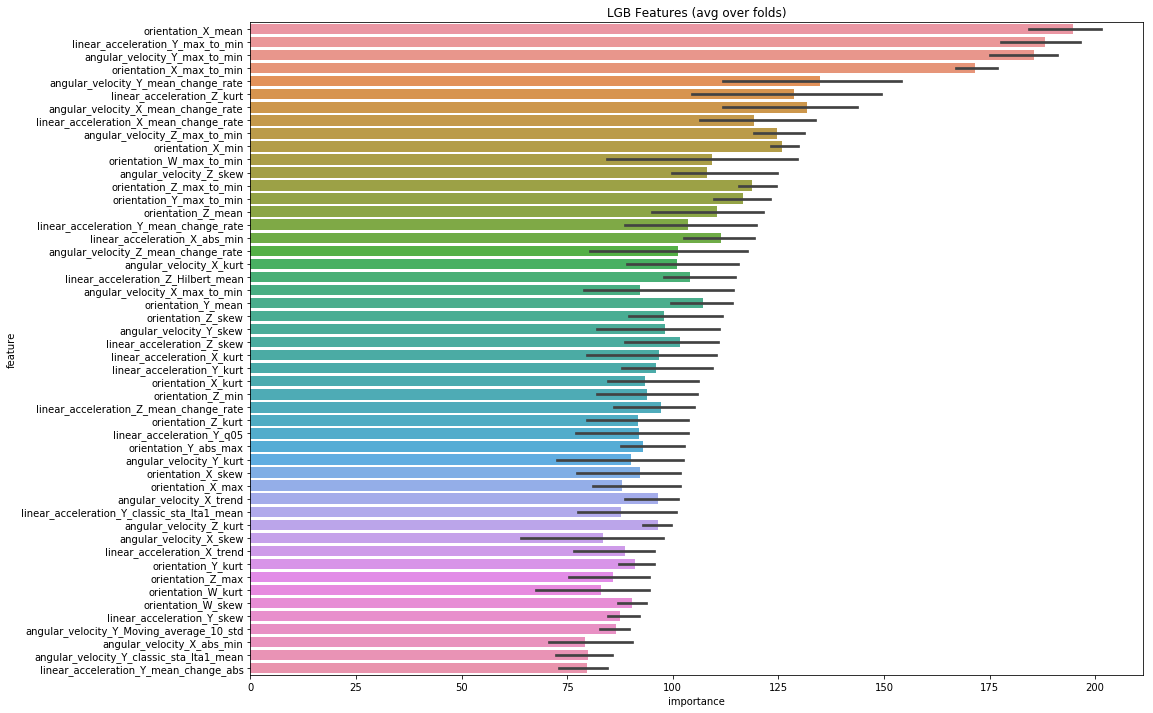

In [27]:
params = {'num_leaves': int(bo.max['params']['num_leaves']),
          'min_data_in_leaf': int(bo.max['params']['min_child_weight']),
          'min_split_gain': bo.max['params']['min_split_gain'],
          'objective': 'multiclass',
          'max_depth': int(bo.max['params']['max_depth']),
          'learning_rate': bo.max['params']['learning_rate'],
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": bo.max['params']['subsample'],
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': bo.max['params']['reg_alpha'],
          'reg_lambda': bo.max['params']['reg_lambda'],
          "num_class": 9,
          'nthread': -1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X=train_df, X_test=test_df, y=y['surface'], params=params, model_type='lgb', plot_feature_importance=True)

In [28]:
# I use code from this kernel: https://www.kaggle.com/theoviel/deep-learning-starter
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

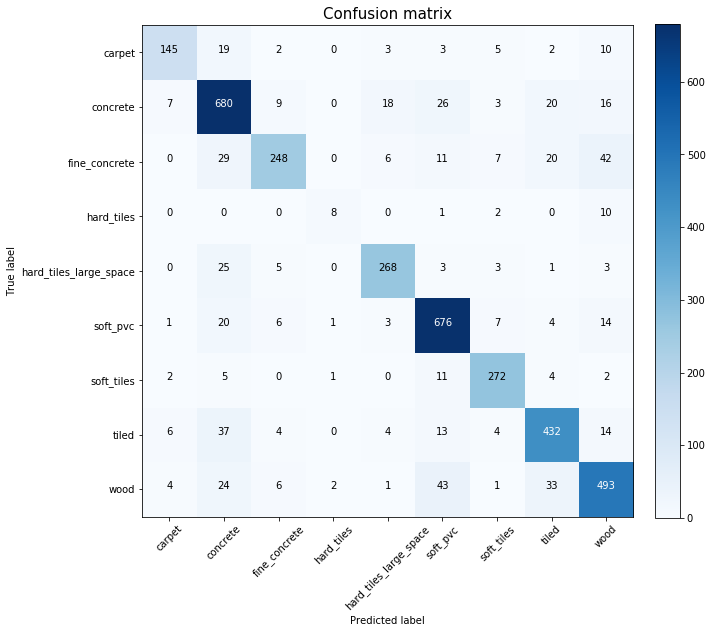

In [29]:
plot_confusion_matrix(y['surface'], oof_lgb.argmax(1), le.classes_)

## Model interpretation

### ELI5

In [30]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y['surface'], test_size=0.2, stratify=y['surface'])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=5000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.00350148	valid_1's multi_logloss: 0.367397


LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, bagging_seed=11,
        boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.5,
        max_depth=95, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=2, min_split_gain=0.001, n_estimators=20000,
        n_jobs=-1, nthread=-1, num_class=9, num_leaves=124,
        objective='multiclass', random_state=None, reg_alpha=0.001,
        reg_lambda=15.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [31]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

## Blending

In [32]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(train_df))
X_test_scaled = pd.DataFrame(scaler.transform(test_df))

In [33]:
model = SVC(probability=True)
oof_svc, prediction_svc = train_model(X=X_train_scaled, X_test=X_test_scaled, y=y['surface'], params=None, model_type='sklearn', model=model)

Fold 0 started at Wed Apr 10 22:03:10 2019
Fold 0. Accuracy: 0.7068.

Fold 1 started at Wed Apr 10 22:03:31 2019
Fold 1. Accuracy: 0.7071.

Fold 2 started at Wed Apr 10 22:03:52 2019
Fold 2. Accuracy: 0.6972.

CV mean score: 0.7037, std: 0.0046.


In [34]:
sub['surface'] = le.inverse_transform(prediction_lgb.argmax(1))
sub.to_csv('lgb_sub.csv', index=False)
sub['surface'] = le.inverse_transform(prediction_svc.argmax(1))
sub.to_csv('scv_sub.csv', index=False)
sub['surface'] = le.inverse_transform((prediction_lgb + prediction_svc).argmax(1))
sub.to_csv('blend.csv', index=False)